In [1]:
# @title Running in Colab

from IPython.display import HTML, Javascript, display

display(
    HTML(
        """<a href="https://colab.research.google.com/github/evan-lloyd/mechinterp-experiments/blob/main/next_layer_sae/e2e_demo.ipynb" target="_blank" id="colab-button">
            <button style="background-color: #4285f4; color: white; padding: 10px 20px; border: none; border-radius: 4px; cursor: pointer; font-size: 14px;">
                Run this notebook in Google Colab
            </button>
        </a>"""
    )
)
display(
    Javascript("""
        setTimeout(() => {
            if(typeof google.colab != "undefined") {
                document.querySelector("#colab-button").remove()
            }
        }, 0);
        """)
)

<IPython.core.display.Javascript object>

# Initialize notebook environment


In [2]:
import os

# If we're running in Colab, we need to clone the non-notebook source from git.
if os.getenv("COLAB_RELEASE_TAG") and not os.path.isdir(
    "/content/mechinterp-experiments"
):
    ip = get_ipython()  #  pyright: ignore[reportUndefinedVariable]
    ip.run_cell_magic(
        "bash",
        "",
        """
    git clone --filter=blob:none --no-checkout https://github.com/evan-lloyd/mechinterp-experiments.git
    cd mechinterp-experiments
    git sparse-checkout init --no-cone
    echo "/next_layer_sae" > .git/info/sparse-checkout
    git checkout
  """,
    )
    ip.run_line_magic("cd", "mechinterp-experiments/next_layer_sae")
else:
    print("Already cloned source, or not running in Colab.")

# Nice for dev, but not needed for Colab.
try:
    # This uses a library called jurigged to hot-reload code when it is changed.
    # For reasons I've never been able to figure out, the IPython %autoreload magic
    # completely fails to work with the kind of structure I use in this notebook.
    import next_layer_sae._autoreload
except Exception:
    raise

Already cloned source, or not running in Colab.


In [3]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

# Tweak TRAINING_BATCH_SIZE for your hardware if necessary
if torch.cuda.is_available():
    TRAINING_DEVICE = "cuda"
    TRAINING_BATCH_SIZE = 64
    E2E_BATCH_SIZE = 8
elif torch.mps.is_available():
    TRAINING_DEVICE = "mps"
    TRAINING_BATCH_SIZE = 8
    E2E_BATCH_SIZE = 2
else:
    TRAINING_DEVICE = "cpu"
    TRAINING_BATCH_SIZE = 8
    E2E_BATCH_SIZE = 2

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
training_dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)
validation_dataset = load_dataset(
    "roneneldan/TinyStories", split="validation", streaming=True
)
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-33M").to(
    TRAINING_DEVICE
)

print(model)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_feat

In [4]:
# Caches model activations to these directories; modify if necessary, or set to None to disable.
# These take up ~16GB and ~1.5GB respectively, but will save a fair bit of time when running
# the notebook, since they can be re-used across all methods we're comparing.
TRAINING_CACHE_DIR = ".training_cache"
VALIDATION_CACHE_DIR = ".validation_cache"
NUM_TRAINING_TOKENS = int(1e6)
EVAL_INTERVAL = int(1e5)
NUM_VALIDATION_TOKENS = int(1e5)
D_MODEL = model.config.hidden_size
D_SAE = D_MODEL * 4
TOKENIZER_BATCH_SIZE = 128

# Train SAEs for comparison


In [5]:
from next_layer_sae.sae import SAE
from next_layer_sae.training import TrainingConfig, TrainingMethod, train

saes = {
    method: {
        layer: SAE(
            D_MODEL,
            D_SAE,
            device=model.device,
            kind="topk",
            topk=100,
        )
        for layer in range(model.config.num_layers)
    }
    for method in TrainingMethod
}

training_config = {
    method: TrainingConfig(
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        training_batch_size=TRAINING_BATCH_SIZE,
        e2e_batch_size=E2E_BATCH_SIZE,
        num_train_tokens=NUM_TRAINING_TOKENS,
        dense_weight=0.0,
        idempotency_weight=0.0,
        eval_interval=int(1e4),
        train_layers=list(range(model.config.num_layers)),
        lr=1e-3,
        use_next_layer_sae=method is TrainingMethod.next_layer,
        next_reconstruction_weight=1.0 if method is TrainingMethod.next_layer else 0.0,
        reconstruction_weight=1.0,
        use_kl_on_final_layer=True,
        balance_reconstruction_losses=method is TrainingMethod.next_layer,
        use_weighted_mask=False,
        method=method,
        finetune_fraction=0.10 if method is TrainingMethod.finetuned else None,
    )
    for method in TrainingMethod
}

training_results = {}

In [6]:
import os

from next_layer_sae.training import build_cache

if TRAINING_CACHE_DIR and (
    not os.path.exists(TRAINING_CACHE_DIR) or not os.listdir(TRAINING_CACHE_DIR)
):
    build_cache(
        TRAINING_CACHE_DIR,
        model,
        tokenizer,
        training_dataset,
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        inference_batch_size=TRAINING_BATCH_SIZE,
        num_tokens=NUM_TRAINING_TOKENS,
    )

if VALIDATION_CACHE_DIR and (
    not os.path.exists(VALIDATION_CACHE_DIR) or not os.listdir(VALIDATION_CACHE_DIR)
):
    build_cache(
        VALIDATION_CACHE_DIR,
        model,
        tokenizer,
        validation_dataset,
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        inference_batch_size=TRAINING_BATCH_SIZE,
        num_tokens=NUM_VALIDATION_TOKENS,
    )

## Next-layer auxiliary loss (my method)


In [7]:
training_results[TrainingMethod.next_layer] = train(
    model,
    tokenizer,
    saes[TrainingMethod.next_layer],
    training_dataset,
    training_config[TrainingMethod.next_layer],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/1000000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/1000000 [00:00<?, ?it/s]

## Full end-to-end training

Recreation of the method SAE_e2e+ds from

> Braun, Dan, Jordan Taylor, Nicholas Goldowsky-Dill, and Lee Sharkey. 2024. “Identifying Functionally Important Features with End-to-End Sparse Dictionary Learning.” arXiv [Cs.LG]. arXiv. http://arxiv.org/abs/2405.12241.


In [8]:
training_results[TrainingMethod.e2e] = train(
    model,
    tokenizer,
    saes[TrainingMethod.e2e],
    training_dataset,
    training_config[TrainingMethod.e2e],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

Layer 2

Layer 1

Layer 0

  0%|          | 0/1000000 [00:00<?, ?it/s]

## End-to-end fine-tuning

Recreation of the KL fine-tuning method from

> Karvonen, Adam. 2025. “Revisiting End-to-End Sparse Autoencoder Training: A Short Finetune Is All You Need.” arXiv [Cs.LG]. arXiv. http://arxiv.org/abs/2503.17272.


In [9]:
training_results[TrainingMethod.finetuned] = train(
    model,
    tokenizer,
    saes[TrainingMethod.finetuned],
    training_dataset,
    training_config[TrainingMethod.finetuned],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

  0%|          | 0/900000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/900000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/900000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/900000 [00:00<?, ?it/s]

Layer 3

Layer 2

Layer 1

Layer 0

  0%|          | 0/97873 [00:00<?, ?it/s]

# Evaluations and comparisons


## Train-time evaluations

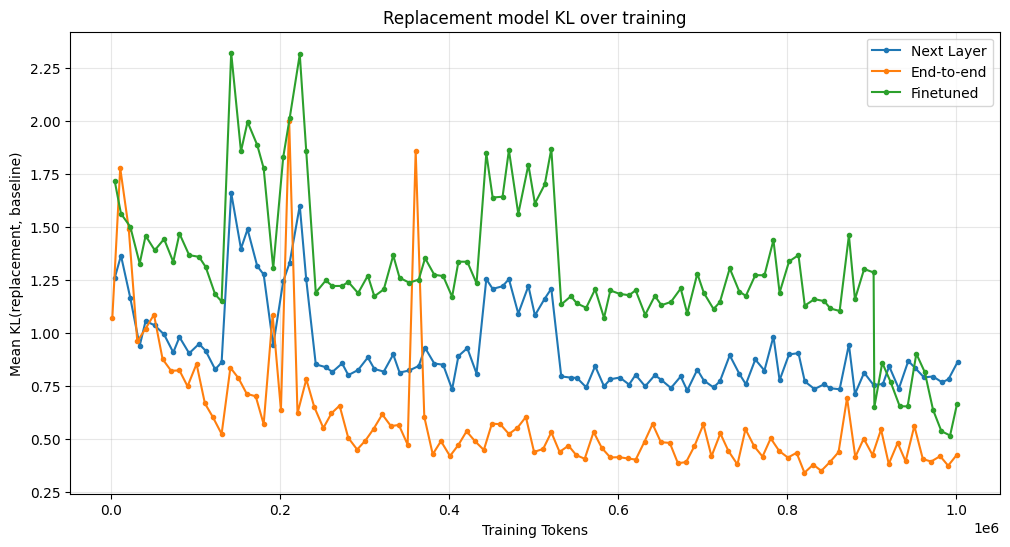

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for method in training_results:
    data = training_results[method][0]['rep_kl']
    tokens, kl_values = zip(*data)
    plt.plot(tokens, kl_values, label=method.value, marker='o', markersize=3)

plt.xlabel('Training Tokens')
plt.ylabel('Mean KL(replacement, baseline)')
plt.title('Replacement model KL over training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


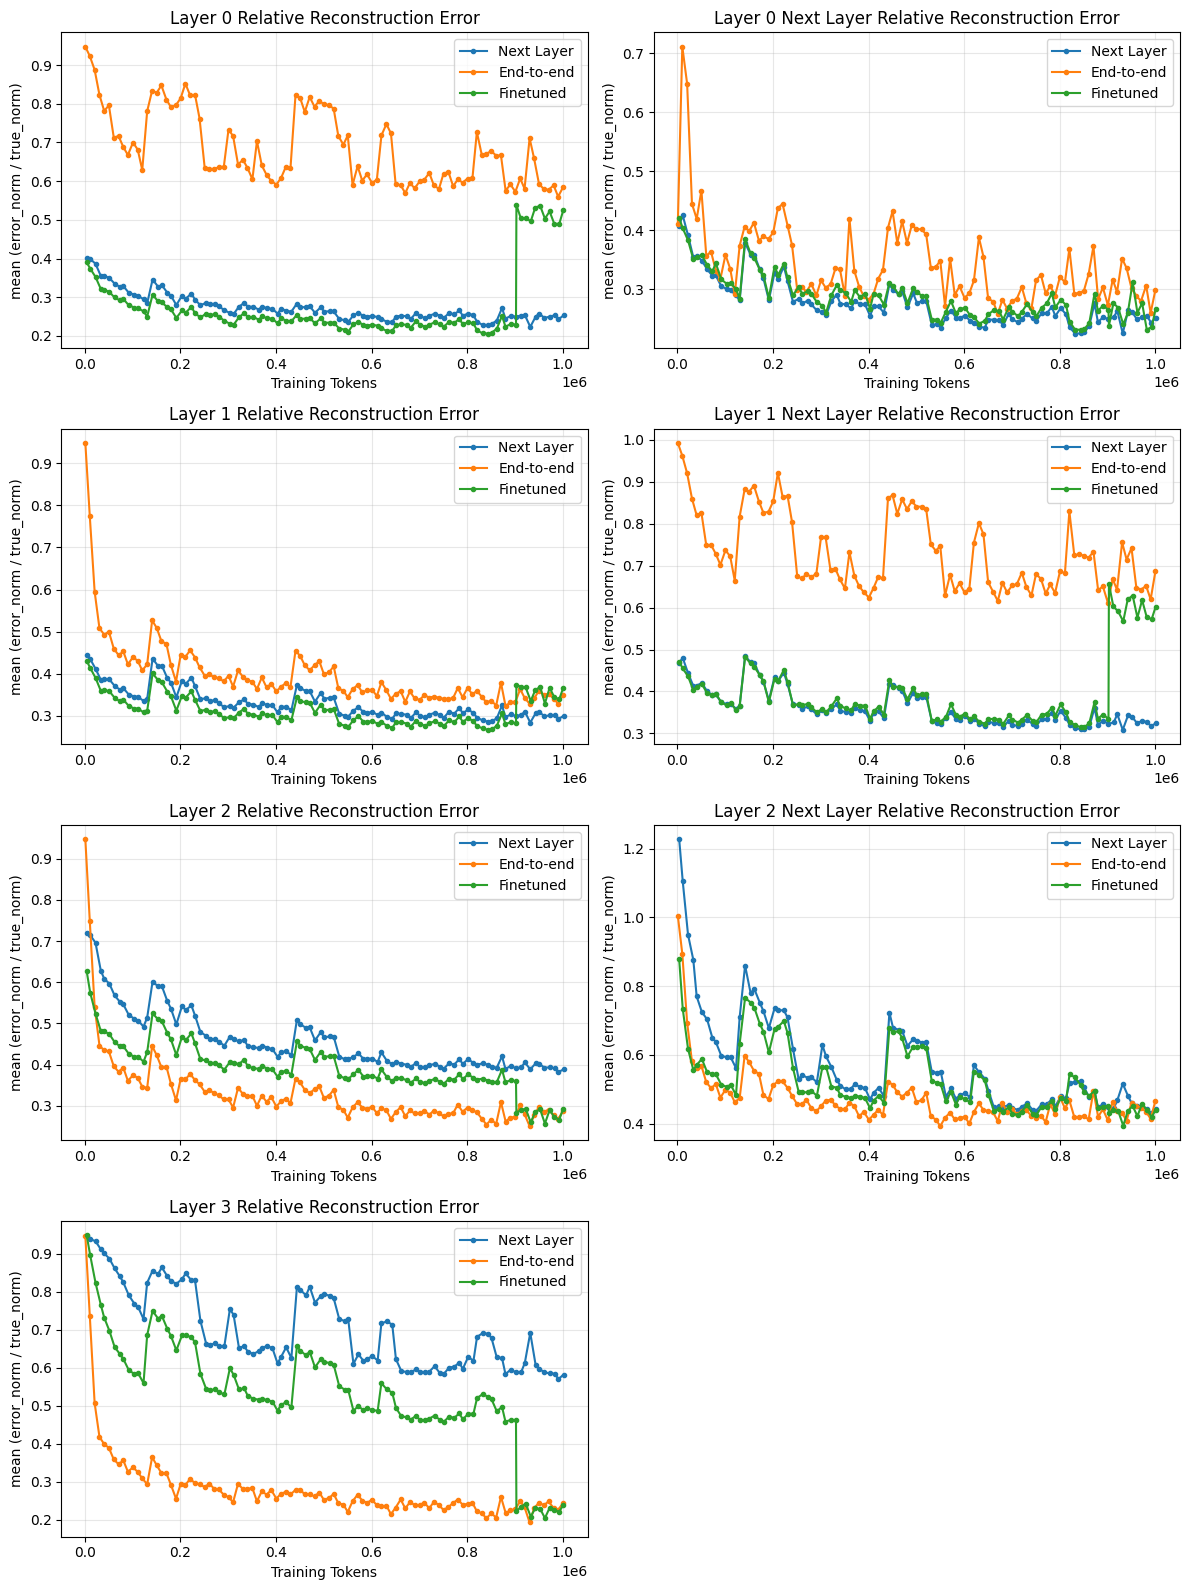

In [11]:
# Get all layers from the training results
layers = set()
for method in training_results:
    layers.update(training_results[method].keys())
layers = sorted(layers)

fig, axes = plt.subplots(len(layers), 2, figsize=(12, 4 * len(layers)))
if len(layers) == 1:
    axes = axes.reshape(1, -1)

for i, layer in enumerate(layers):
    # Plot rcn (relative reconstruction norm)
    ax1 = axes[i, 0]
    for method in training_results:
        data = training_results[method][layer]['rcn']
        tokens, rcn_values = zip(*data)
        ax1.plot(tokens, rcn_values, label=method.value, marker='o', markersize=3)

    ax1.set_xlabel('Training Tokens')
    ax1.set_ylabel('mean (error_norm / true_norm)')
    ax1.set_title(f'Layer {layer} Relative Reconstruction Error')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot next_rcn (next layer relative reconstruction norm)
    if layer != max(layers):
        ax2 = axes[i, 1]
        for method in training_results:
            data = training_results[method][layer]['next_rcn']
            tokens, next_rcn_values = zip(*data)
            ax2.plot(tokens, next_rcn_values, label=method.value, marker='o', markersize=3)

        ax2.set_xlabel('Training Tokens')
        ax2.set_ylabel('mean (error_norm / true_norm)')
        ax2.set_title(f'Layer {layer} Next Layer Relative Reconstruction Error')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        axes[i, 1].set_visible(False)

plt.tight_layout()
plt.show()
